# MCMC Example

The idea of this notebook is to guide you to the process of Bayesian calibration for DSSAT Model. To do this type of calibration you need the next things:
- Set of parameters to calibrate (You can define those from a sensitivity analysis)
- Prior distribution of your paramters
- Optional: support of your parameters: valid values for the samples taken for every parameter.

The prior distribution of your parameters is the information that you have regarding the distribution for every parameter. Usually you would define that from previous works, or in the case of DSSAT, you can define those from the values of different crops, or the crops you consider can be suited to your analysis.

At the end of the process, you will obtain a posterior distribution of every parameter. For this example we will be simulating observations (model output) with know parameters. i.e. we will set the parameters to generate the output, and we will check if the MCMC sampler is able to get the same value for those parameters.

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from DSSATTools.run import CSM_EXE
from DSSATTools.dssatUtils import CropParser
import pickle
import os
import shutil
import multiprocessing
import tqdm
from scipy.stats import (
    gamma, uniform, norm, invgamma, expon, beta, 
    multivariate_normal, invwishart, lognorm
)
import pandas as pd
from DSSATTools.MCMC import MCMC, setup_paralell_env
import copy
warnings.filterwarnings('ignore')

In [212]:
# A list of your paramters
PARAMS = ['FNPTD(4)&4', 'LFMAX', 'RDRMT', 'RDRMG', 'RWDTH',
          'FNPTD(4)&3', 'XLMAXT (6 VALUES)&2', 'RHGHT',
          'FNPTD(4)&2', 'SLAVR']
# A dict indicating the file some parameters belong to
PAR_GROUPS = {
    'CSDL': 'cul', 'PPSEN': 'cul', 'EM-FL': 'cul', 'FL-SH': 'cul', 
    'FL-SD': 'cul', 'SD-PM': 'cul', 'FL-LF': 'cul',
    'LFMAX': 'cul', 'SLAVR': 'cul', 'SIZLF': 'cul', 'TRIFL': 'eco',
    'RWDTH': 'eco', 'RHGHT': 'eco', 'RDRMT': 'eco',
    'RDRMG': 'eco', 'RDRMM': 'eco', 'RCHDP': 'eco',
    'XLMAXT (6 VALUES)&1': 'pho', 'XLMAXT (6 VALUES)&2': 'pho', 'XLMAXT (6 VALUES)&3': 'pho',
    'FNPGT(4)&1': 'pho', 'FNPGT(4)&2': 'pho',
    'XSLATM(1-5)&2': 'lfg', 'XSLATM(1-5)&3': 'lfg', 'FREEZ1': 'lfs', 'FREEZ2': 'lfs',
    'RWUEP1': 'roo', 'RFAC1': 'roo', 'RLDSM': 'roo',
    'EORATIO': 'eto', 'KEP': 'eto', 'FNPTD(4)&2': 'dor', 'FNPTD(4)&3': 'dor',
    'FNPTD(4)&4': 'dor', 'FNPMD(4)&1': 'dor', 'FNPMD(4)&2': 'dor', 
    'HARD1': 'dor', 'HARD2': 'dor', 'FRZDC': 'dor'
}
# real parameters
PARAMS = {'FNPTD(4)&4': 0.148, 'LFMAX': 1.4, 'RDRMT': 0.4, 'RDRMG':1, 'RWDTH': 1,
          'FNPTD(4)&3': 12.2, 'XLMAXT (6 VALUES)&2': 0.2, 'RHGHT': 1,
          'FNPTD(4)&2': 11.1, 'SLAVR': 280}
# Just including the parameters that we will calibrate
PAR_GROUPS = {key: value for key, value in PAR_GROUPS.items() if key in PARAMS}

# parameters' support
PARS_SUPPORT = {'FNPTD(4)&4': (0, 1), 'LFMAX': (.5, 3.5), 'RDRMT': (0, 3), 'RDRMG': (0, 3), 'RWDTH': (0, 3),
          'FNPTD(4)&3': (10, 16), 'XLMAXT (6 VALUES)&2': (-5, 5), 'RHGHT': (0, 3),
          'FNPTD(4)&2': (9, 13), 'SLAVR': (100, 500)}

In [213]:
# Load priors
with open('priors_3.pkl', 'rb') as f:
    priors = pickle.load(f)

# Include the file hosting each parameter
for key in list(priors.keys())[:-1]: priors[key]['file'] = PAR_GROUPS[key]
del priors['SIGMA']

In [214]:
# How priors object looks like
priors

{'FNPTD(4)&4': {'dist': <scipy.stats._continuous_distns.uniform_gen at 0x7f9510bb2610>,
  'pars': (0, 1),
  'file': 'dor'},
 'LFMAX': {'dist': <scipy.stats._continuous_distns.gamma_gen at 0x7f9471d3caf0>,
  'pars': (12.54850258486588, 0, 0.09702160797885605),
  'file': 'cul'},
 'RDRMT': {'dist': <scipy.stats._continuous_distns.lognorm_gen at 0x7f9510cdf100>,
  'pars': (0.5099238119614368, 0.0, 0.8110110986839564),
  'file': 'eco'},
 'RDRMG': {'dist': <scipy.stats._continuous_distns.gamma_gen at 0x7f9471d3caf0>,
  'pars': (31.4721260163957, 0, 0.03391918059066887),
  'file': 'eco'},
 'RWDTH': {'dist': <scipy.stats._continuous_distns.gamma_gen at 0x7f9471d3caf0>,
  'pars': (28.956448881781725, 0, 0.03295108065666582),
  'file': 'eco'},
 'FNPTD(4)&3': {'dist': <scipy.stats._continuous_distns.gamma_gen at 0x7f9471d3caf0>,
  'pars': (83.20598054680568, 0, 0.17307372790891262),
  'file': 'dor'},
 'XLMAXT (6 VALUES)&2': {'dist': <scipy.stats._continuous_distns.norm_gen at 0x7f9471d3b310>,
  '

In [215]:
# Harvest Dates in case that observations are not provided
# In this case we will be simulating data with the model giving those
# harvest dates. On a real problem you would get your harvest dates
# from the observations
HARVEST_DATES = pd.to_datetime(['21165', '21195', '21227', '21265'], format='%y%j')
HARVEST_DATES

DatetimeIndex(['2021-06-14', '2021-07-14', '2021-08-15', '2021-09-22'], dtype='datetime64[ns]', freq=None)

In [218]:
# Initialize the directories to run DSSAT.
# We will be runing 4 chains in 4 cores
NCores = 4
DSSATEnvList = setup_paralell_env(cores=NCores, DSSATFolder='/mnt/c/DSSAT47', crop='AL')

Intializing working directories
Initializing working directory for cpu 0
DSSAT Executable at /mnt/c/Model_Calibration/wdir/00/DSSAT47/DSCSM047.EXE
Initializing working directory for cpu 1
DSSAT Executable at /mnt/c/Model_Calibration/wdir/01/DSSAT47/DSCSM047.EXE
Initializing working directory for cpu 2
DSSAT Executable at /mnt/c/Model_Calibration/wdir/02/DSSAT47/DSCSM047.EXE
Initializing working directory for cpu 3
DSSAT Executable at /mnt/c/Model_Calibration/wdir/03/DSSAT47/DSCSM047.EXE


In [219]:
#
# Run function
CropFile = CropParser('/home/diego/Py_DSSATTools/test/ALFRM047.SPE', raise_missing_pars=False)
def runModel(theta, core, priors=priors, DSSATEnvList=DSSATEnvList, OBS=None):
    '''
    This function is the one that you pass as responses, for the MCMC class. This function
    basically recieve as input the sampled parameters (array), and return as output a dict
    with the obtained values from those input parameters. You can define your function
    whatever you want. The important thing is that it must receive as input a 1D array 
    of parameters, and it must return a dict for the observations. The input 1D array is
    in the same order as the keys in the priors dict. The output dict should contain the same
    keys as the observation object passed to the MCMC.sample call.
    -------
    Arguments:
        theta: list
            Vector of parameters
        core: int
            core for that process
        priors: dict
            priors object
        DSSATEnvList: list
            List with CSM_EXE instances to be executed
        OBS: 
            Whatever object you like to handle your observations
    '''
    # Set some parameters
    priors = copy.deepcopy(priors)
    DSSATEnv = DSSATEnvList[core]
    if core == None:
        DSSATEnv = DSSATEnvList
    N = f'{core:02d}'
    del priors['SIGMA']
    pars = {key: value['file'] for key, value in priors.items()}
    
    # Modify crop files according to input parameters
    CUL_INDEX = 1
    ECO_INDEX = 0
    for n, (key, group) in enumerate(pars.items()):
        if '&' in key:
            key, index = key.split('&')
        par = CropFile.parameters.get(key)
        if group == 'cul':
            par[CUL_INDEX] = theta[n]
        elif group == 'eco':
            par[ECO_INDEX] = theta[n]
        elif isinstance(par, list):
            index = int(index) - 1
            par[index] = theta[n]
        else:
            pass
        CropFile.set_parameter(key, par)
    CropFile.write(os.path.join(os.getcwd(), 'wdir', str(N), 'ALFRM047'))
    
    # Run the model
    DSSATEnv.runDSSAT(
        experimental='/home/diego/Py_DSSATTools/test/UNVR2001.ALX',
        crop='AL', 
        wth_folder='/home/diego/Py_DSSATTools/weather/',
        soil_profile='/home/diego/Py_DSSATTools/test/ValleyRoad.SOL',
        wdir=os.path.join(os.getcwd(), 'wdir', str(N)),
        crop_file=os.path.join(os.getcwd(), 'wdir', str(N),'ALFRM047.SPE'),
        treatments=[1, 2, 3]
    )
    
    # Get the outputs
    df = pd.concat([DSSATEnv.results.getOutput('PlantGro', i) for i in range(1, 4)])
    df = df.set_index(pd.to_datetime(df['@YEAR'] + df.DOY, format='%Y%j'))
    df = df[['SWAD', 'LWAD', 'CHTCM', 'LAID']]
    df = df.astype(float)
    if OBS == None:
        df = df.loc[df.index.isin(HARVEST_DATES)]
    else:
        df = df.loc[df.index.isin(OBS.Date)]
    df['SWAD_Adj'] = df['SWAD'] * (1 - 5/df['CHTCM']) # Removing non-harvested steam
    df['yield'] = df['SWAD_Adj'] + df['LWAD']
    df['height'] = df['CHTCM']
    df['lai'] = df['LAID']
    df = df[['yield', 'height', 'lai']]
    out = {response: values for response, values in zip(df.columns, df.to_numpy().T)}
    return out

In [9]:
# Run a simulation to get the values obtained with the input parameters
observations = runModel(list(PARAMS.values()), 0, priors)
# How the observations object looks like
observations

{'yield': array([7199.53763441, 3822.85714286, 3376.05555556, 3828.02777778,
        7155.98924731, 3931.61111111, 3455.2972973 , 3847.19444444,
        7144.31182796, 3963.44444444, 3439.2972973 , 3763.11111111]),
 'height': array([93., 35., 36., 36., 93., 36., 37., 36., 93., 36., 37., 36.]),
 'lai': array([10.44,  6.54,  5.27,  6.04, 10.4 ,  6.94,  5.61,  6.13, 10.39,
         7.16,  5.62,  5.89])}

In [220]:
# Set the MCMC sampler instance
mcmc = MCMC(
    priors=priors,
    responses=runModel,
)

We will be runing the burnin stage of the sampler in batches. Why? well, it takes a long to sample the parameters, and It'll take longer the more parameters you have. You wouldn't like your sampling time to be wasted in case that something goes wrong. That's why we are running it on batches, and saving the trace at the end of every batch. In that case, if something goes wrong, you don't have to start from nothing, you can start from your last trace.

During the burnin stage the sampler is going to addapt the scale parameter for every DSSAT parameter. It's like the adaptation stage of the sampler. The tuning_interval argument in `MCMC.sample` defines how often to perform the adaptation step.

In [ ]:
# Run 7 batches of 51 iterations
for i in range(7):
    if i != 0: 
        # Open the previous trace
        with open(f'mcmc_trace_3_{i-1}.pkl', 'rb') as f:
            previous_trace = pickle.load(f)
    else:
        # For the first iteration there's not previous trace
        previous_trace = None

    mcmc.sample(
        observations=observations,
        tuning_interval=25,
        cores=NCores,
        burnin=51,
        n_iter=0,
        chains=NCores,
        support=PARS_SUPPORT,
        previous_trace=previous_trace
    )
    # Save the trace for this iteration
    mcmc.save_trace(f'mcmc_trace_3_{i}')

In [ ]:
# Run again, but not burnin, real sampling
with open(f'mcmc_trace_3_6.pkl', 'rb') as f:
    previous_trace = pickle.load(f)

mcmc.sample(
        observations=observations,
        tuning_interval=50,
        cores=NCores,
        burnin=0,
        n_iter=200,
        chains=NCores,
        support=PARS_SUPPORT,
        previous_trace=previous_trace
    )
mcmc.save_trace('mcmc_trace_3_final')

In [ ]:
# Run another 200 iterations
with open(f'mcmc_trace_3_final.pkl', 'rb') as f:
    previous_trace = pickle.load(f)

mcmc.sample(
        observations=observations,
        tuning_interval=50,
        cores=NCores,
        burnin=0,
        n_iter=200,
        chains=NCores,
        support=PARS_SUPPORT,
        previous_trace=previous_trace
    )

mcmc.save_trace('mcmc_trace_3_final_2')

In [209]:
!ls -ltrh /mnt/c/Users/dandres/Dev_DSSATTools/mcmc_trace_3*

-rw-r--r-- 1 diego diego  86K May 15 13:57 /mnt/c/Users/dandres/Dev_DSSATTools/mcmc_trace_3_0.pkl
-rw-r--r-- 1 diego diego 168K May 15 15:24 /mnt/c/Users/dandres/Dev_DSSATTools/mcmc_trace_3_1.pkl
-rw-r--r-- 1 diego diego 250K May 15 19:08 /mnt/c/Users/dandres/Dev_DSSATTools/mcmc_trace_3_2.pkl
-rw-r--r-- 1 diego diego 331K May 15 20:27 /mnt/c/Users/dandres/Dev_DSSATTools/mcmc_trace_3_3.pkl
-rw-r--r-- 1 diego diego 412K May 15 21:50 /mnt/c/Users/dandres/Dev_DSSATTools/mcmc_trace_3_4.pkl
-rw-r--r-- 1 diego diego 493K May 15 23:14 /mnt/c/Users/dandres/Dev_DSSATTools/mcmc_trace_3_5.pkl
-rw-r--r-- 1 diego diego 575K May 16 00:41 /mnt/c/Users/dandres/Dev_DSSATTools/mcmc_trace_3_6.pkl
-rw-r--r-- 1 diego diego 817K May 16 08:08 /mnt/c/Users/dandres/Dev_DSSATTools/mcmc_trace_3_final.pkl
-rw-r--r-- 1 diego diego 1.2M May 16 14:00 /mnt/c/Users/dandres/Dev_DSSATTools/mcmc_trace_3_final_2.pkl


In [208]:
with open('/mnt/c/Users/dandres/Dev_DSSATTools/mcmc_trace_3_final_2.pkl', 'rb') as f:
    trace = pickle.load(f)
samples_debug = trace['samples']

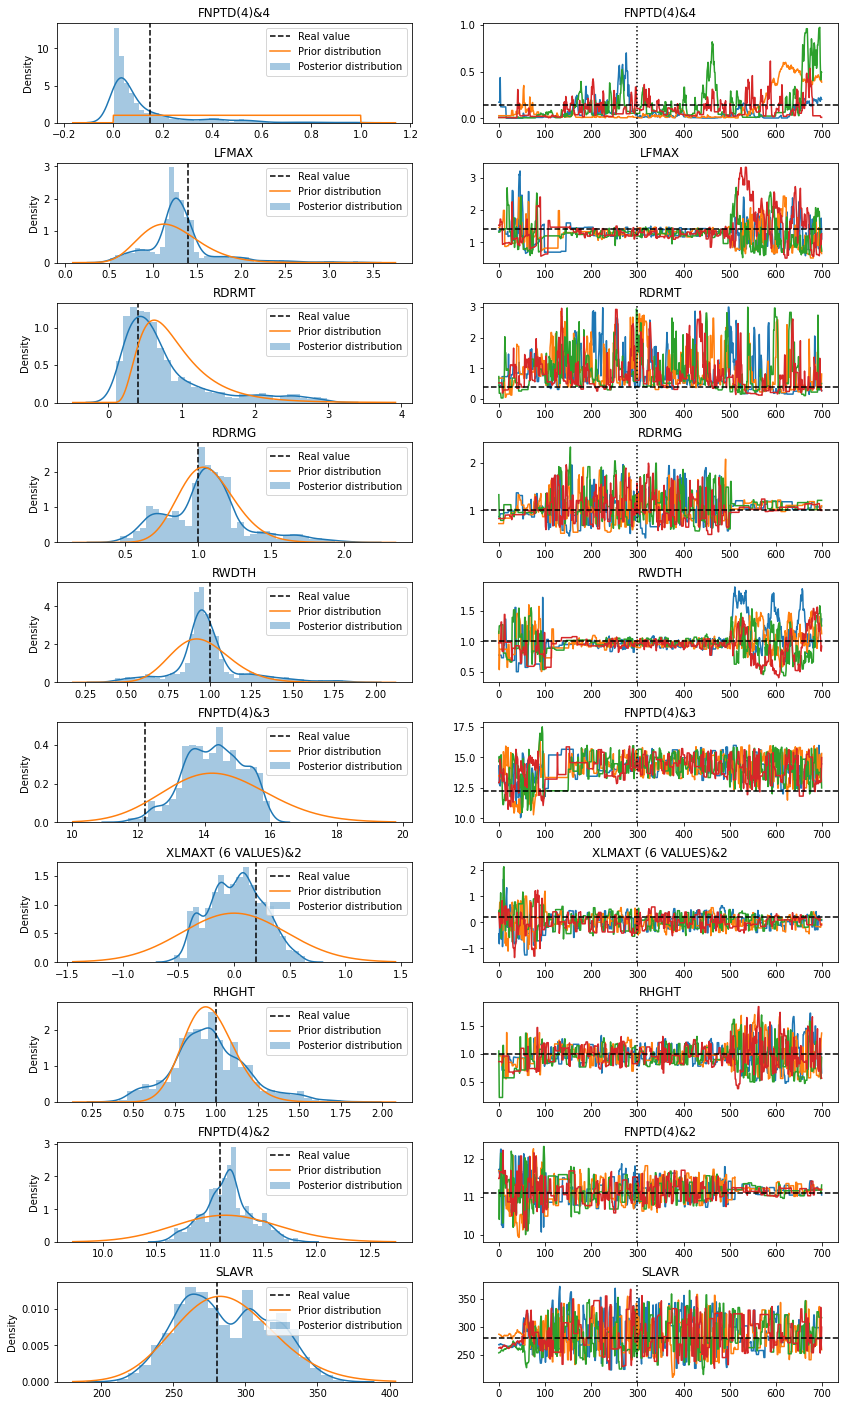

In [221]:
# Plot the traceplot, and the distribution for the last 500 iterations
fig, ax = plt.subplots(10, 2, figsize=(14, 25))
x = samples_debug.shape[1] - 2
for n, par in enumerate(PARAMS.keys()):
    for chain in range(4):
        ax[n][1].plot(range(x), samples_debug[chain, :x, n])
    ax[n][1].axhline(PARAMS[par], color='k', linestyle='--')
#     ax[n].axvline(500, color='r')
    ax[n][1].set_title(par)
    ax[n][1].axvline(300, color='k', linestyle=':')
    sns.distplot(
        samples_debug[:, -500:x, n],
        ax=ax[n][0],
        label='Posterior distribution'
    )
    ax[n][0].axvline(PARAMS[par], color='k', linestyle='--', label='Real value')
    ax[n][0].set_title(par)
    xmin, xmax = ax[n][0].get_xlim()
    xmin = min(xmin, priors[par]['dist'].ppf(.001, *priors[par]['pars']))
    xmax = max(xmax, priors[par]['dist'].ppf(.999, *priors[par]['pars']))
    X = np.linspace(xmin, xmax, 1000)
    ax[n][0].plot(X, priors[par]['dist'].pdf(X, *priors[par]['pars']), label='Prior distribution')
    ax[n][0].legend()
plt.subplots_adjust(hspace=.4)

Please note how the resulting posterior distributions include the real parameter. If we estimate the paramters as the mean of the posterior, the results would be as follow:

In [223]:
records = {}
for n, (par, value) in enumerate(PARAMS.items()):
    records[n] = {'Parameter': par, 'Real': value, 'Post_Mean': samples_debug[:, -500:, n].mean()}
pd.DataFrame.from_records(records).T

,Parameter,Real,Post_Mean
0,FNPTD(4)&4,0.148,0.12221
1,LFMAX,1.4,1.302602
2,RDRMT,0.4,0.779545
3,RDRMG,1,1.049004
4,RWDTH,1,0.985738
5,FNPTD(4)&3,12.2,14.223126
6,XLMAXT (6 VALUES)&2,0.2,0.019612
7,RHGHT,1,0.959879
8,FNPTD(4)&2,11.1,11.126575
9,SLAVR,280,285.270749


There are some parameters whose mean is not that close to the real value. But well, we are not doing B

In [211]:
# Check acceptance rate
trace['acceptance'][:, -400:, :].mean(axis=1)

array([[0.63  , 0.4975, 0.435 , 0.225 , 0.7325, 0.3075, 0.3225, 0.5   ,
        0.225 , 0.3675, 1.    ],
       [0.7375, 0.3975, 0.44  , 0.2625, 0.7225, 0.51  , 0.3425, 0.4625,
        0.3125, 0.44  , 1.    ],
       [0.45  , 0.6   , 0.3825, 0.305 , 0.56  , 0.545 , 0.275 , 0.4325,
        0.1875, 0.36  , 1.    ],
       [0.45  , 0.6025, 0.435 , 0.2575, 0.7025, 0.4025, 0.32  , 0.5125,
        0.3   , 0.32  , 1.    ]])

In [207]:
samples_debug[:, :, -1].mean() / samples_debug[:, :, -1].mean().mean()

array([[ 2.97443783e+00, -2.86354055e-03,  1.28749589e-02],
       [-2.86354055e-03,  3.19763006e+00,  1.81390249e-02],
       [ 1.28749589e-02,  1.81390249e-02,  2.77163122e+00]])